# smoking_status and bmi = most frequent

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [3]:
data = pd.read_csv('data/dataset.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [5]:
data.bmi.fillna(data.bmi.mode().iloc[0], inplace=True)
data.smoking_status.fillna('never smoked', inplace=True)

## correlation matrix for numerical data: Pearson

In [6]:
categorical_data = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_corr = data.drop(categorical_data, axis=1).corr()
num_corr.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.012760,0.006571,0.009234,0.024634,0.021039,0.002976
age,0.012760,1.000000,0.272169,0.250188,0.237627,0.350231,0.156049
hypertension,0.006571,0.272169,1.000000,0.119777,0.160211,0.151361,0.075332
heart_disease,0.009234,0.250188,0.119777,1.000000,0.146938,0.051753,0.113763
avg_glucose_level,0.024634,0.237627,0.160211,0.146938,1.000000,0.181899,0.078917
bmi,0.021039,0.350231,0.151361,0.051753,0.181899,1.000000,0.016073
stroke,0.002976,0.156049,0.075332,0.113763,0.078917,0.016073,1.000000


In [7]:
# so we can drop id and bmi since they have very small impact on stroke
dropped_data_1 = data.drop(['id', 'bmi'], axis=1)

from here we can see there are missing values in smoking_status and bmi

I choose to check what to do with these missed values. Here my options: 
1. Drop those people from my training set 
2. Replace the Nan with the mean of the column
3. Replace the Nan with the max of the column
4. Replace the Nan with the most frequent value of the column

## correlation matrix for categorical data: Cramer's V

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("Cross Correlation plot on Dataframe with CrammerV Correlation Values")
    plt.show()

Else condition Met:  0.9999999999999999
Else condition Met:  0.030963530214187737
Else condition Met:  0.06330708849977167
Else condition Met:  0.0
Else condition Met:  0.03756532354689769
Else condition Met:  0.009317660176099647
Else condition Met:  0.030963530214187737
Else condition Met:  0.9999497647278632
Else condition Met:  0.56834175668848
Else condition Met:  0.0
Else condition Met:  0.22214436771523005
Else condition Met:  0.07157882306692893
Else condition Met:  0.06330708849977167
Else condition Met:  0.56834175668848
Else condition Met:  1.0
Else condition Met:  0.0
Else condition Met:  0.19354324487915173
Else condition Met:  0.07534777542412728
Else condition Met:  0.0
Else condition Met:  0.0
Else condition Met:  0.0
Else condition Met:  0.9999539156818897
Else condition Met:  0.006039629345240704
Else condition Met:  0.0
Else condition Met:  0.03756532354689769
Else condition Met:  0.22214436771523005
Else condition Met:  0.19354324487915173
Else condition Met:  0.006

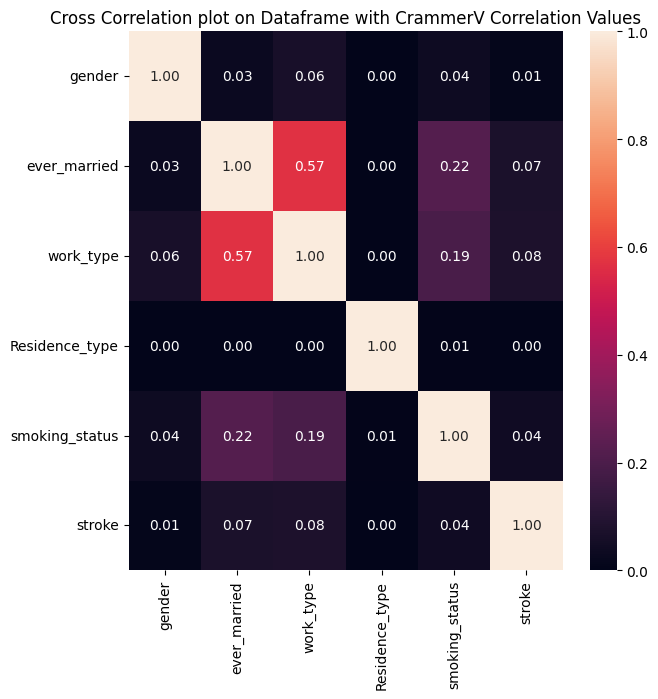

In [9]:
categorical_data1 = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
data1 = dropped_data_1.copy()
data1['stroke'] = dropped_data_1['stroke'].replace({0:'No', 1:'Yes'})

plot_cramer(data1[categorical_data1])

In [10]:
# we can drop Residence and gender
final_data = dropped_data_1.drop(['Residence_type', 'gender'], axis=1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                43400 non-null  float64
 1   hypertension       43400 non-null  int64  
 2   heart_disease      43400 non-null  int64  
 3   ever_married       43400 non-null  object 
 4   work_type          43400 non-null  object 
 5   avg_glucose_level  43400 non-null  float64
 6   smoking_status     43400 non-null  object 
 7   stroke             43400 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 2.6+ MB


In [12]:
target = final_data.stroke

replacement_map = {
    'ever_married':{'Yes':1, 'No':0},
}


first_x = final_data.replace(replacement_map)
x = pd.get_dummies(first_x, columns=['work_type', 'smoking_status'])

In [14]:
features = x.copy()

In [23]:
normalized = pd.DataFrame(Normalizer().fit_transform(x[['avg_glucose_level', 'age']]), columns=['avg_glucose_level', 'age'])
features.avg_glucose_level = normalized[['avg_glucose_level']]
features.age = normalized[['age']]
features

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.031523,0,0,0,0.999503,0,False,False,False,False,True,False,True,False
1,0.550488,1,0,1,0.834843,0,False,False,True,False,False,False,True,False
2,0.071957,0,0,0,0.997408,0,False,False,True,False,False,False,True,False
3,0.711972,0,0,1,0.702208,0,False,False,True,False,False,True,False,False
4,0.086480,0,0,0,0.996254,0,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,0.168105,0,0,0,0.985769,0,False,False,False,False,True,False,True,False
43396,0.253590,0,0,1,0.967312,0,True,False,False,False,False,True,False,False
43397,0.665612,1,0,1,0.746298,0,False,False,True,False,False,True,False,False
43398,0.374098,0,0,1,0.927389,0,False,False,True,False,False,False,True,False


In [24]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             43400 non-null  float64
 1   hypertension                    43400 non-null  int64  
 2   heart_disease                   43400 non-null  int64  
 3   ever_married                    43400 non-null  int64  
 4   avg_glucose_level               43400 non-null  float64
 5   stroke                          43400 non-null  int64  
 6   work_type_Govt_job              43400 non-null  bool   
 7   work_type_Never_worked          43400 non-null  bool   
 8   work_type_Private               43400 non-null  bool   
 9   work_type_Self-employed         43400 non-null  bool   
 10  work_type_children              43400 non-null  bool   
 11  smoking_status_formerly smoked  43400 non-null  bool   
 12  smoking_status_never smoked     

In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0, stratify=target)
print(f'shape of train dataset is x:{x_train.shape} and y:{y_train.shape}')
print(f'shape of test dataset is x:{x_test.shape} and y:{y_test.shape}')

shape of train dataset is x:(34720, 14) and y:(34720,)
shape of test dataset is x:(8680, 14) and y:(8680,)


Text(0.5, 1.0, 'Percentage of Strokes: Train Data Set')

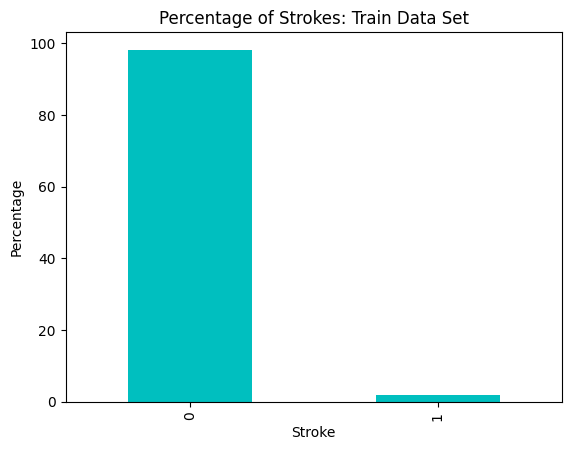

In [30]:
(y_train.value_counts(normalize=True)*100).plot(kind='bar', color='c')
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.title('Percentage of Strokes: Train Data Set')

Text(0.5, 1.0, 'Percentage of Strokes: Test Data Set')

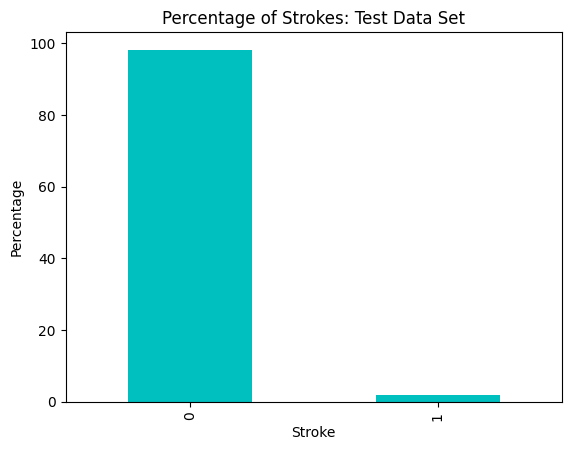

In [31]:
(y_test.value_counts(normalize=True)*100).plot(kind='bar', color='c')
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.title('Percentage of Strokes: Test Data Set')

## SMOTE

In [32]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)

In [33]:
print(x_resampled.shape)
print(y_resampled.shape)

(68188, 14)
(68188,)


Text(0.5, 1.0, 'Percentage of Strokes')

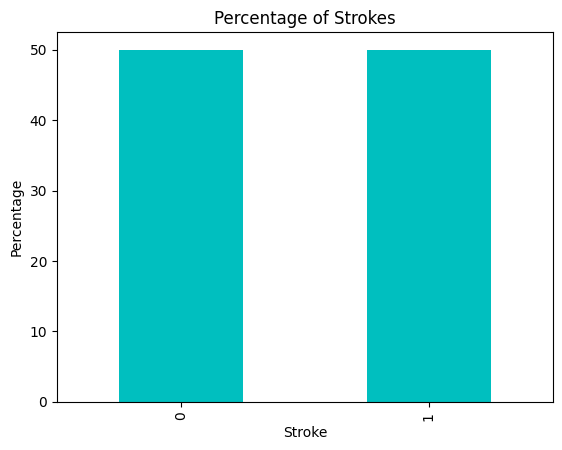

In [34]:
(y_resampled.value_counts(normalize=True)*100).plot(kind='bar', color='c')
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.title('Percentage of Strokes')

In [35]:
x_train_set = []
y_train_set = []
x_test_set = []
y_test_set = []

sgkf = StratifiedKFold(n_splits=3, shuffle=False)
for train_index, test_index in sgkf.split(x_resampled, y_resampled):
    print(f'train is {len(train_index)} and test is {len(test_index)}')
    x_train_cv, x_test_cv = x_resampled.loc[train_index], x_resampled.loc[test_index]
    y_train_cv, y_test_cv = y_resampled.loc[train_index], y_resampled.loc[test_index]
    x_train_set.append(x_train_cv)
    x_test_set.append(x_test_cv)
    y_train_set.append(y_train_cv)
    y_test_set.append(y_test_cv)

train is 45458 and test is 22730
train is 45459 and test is 22729
train is 45459 and test is 22729


stroke
0    22729
1    22729
Name: count, dtype: int64
stroke
1    22730
0    22729
Name: count, dtype: int64
stroke
0    22730
1    22729
Name: count, dtype: int64


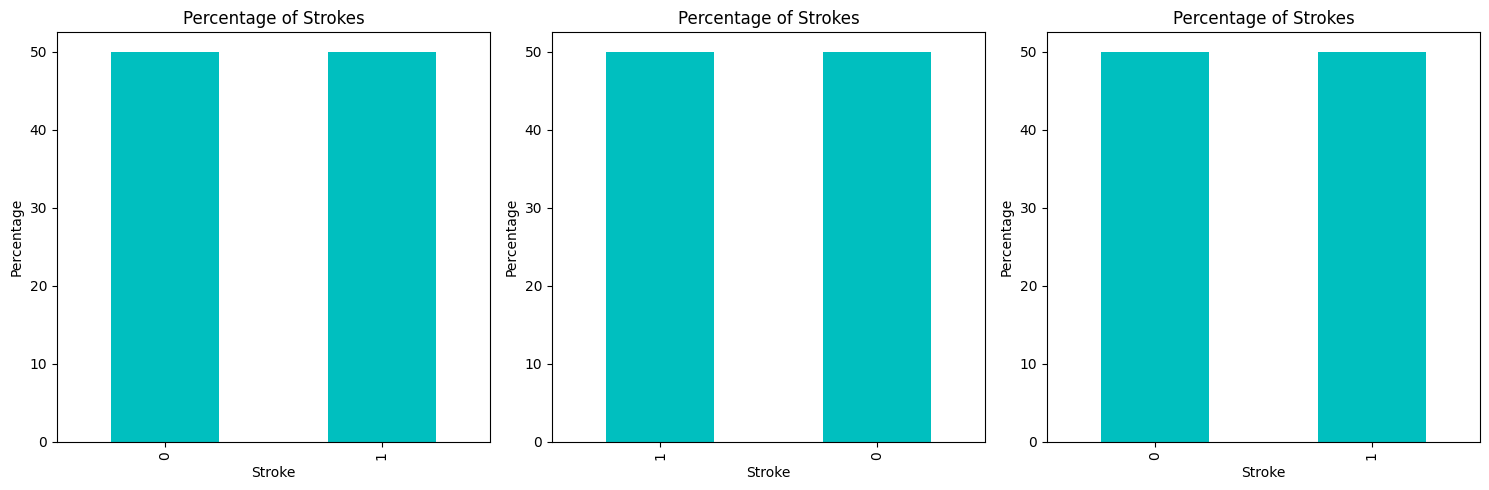

In [36]:
# Create a figure and 5 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting bar plots on each subplot
for i, y_train in zip(range(len(axs)),y_train_set):
    values = (y_train.value_counts(normalize=True)*100)
    print(y_train.value_counts())
    values.plot(kind='bar', color='c', ax=axs[i])
    axs[i].set_xlabel('Stroke')
    axs[i].set_ylabel('Percentage')
    axs[i].set_title('Percentage of Strokes')
    

plt.tight_layout()
plt.show()

stroke
0    11365
1    11365
Name: count, dtype: int64
stroke
0    11365
1    11364
Name: count, dtype: int64
stroke
1    11365
0    11364
Name: count, dtype: int64


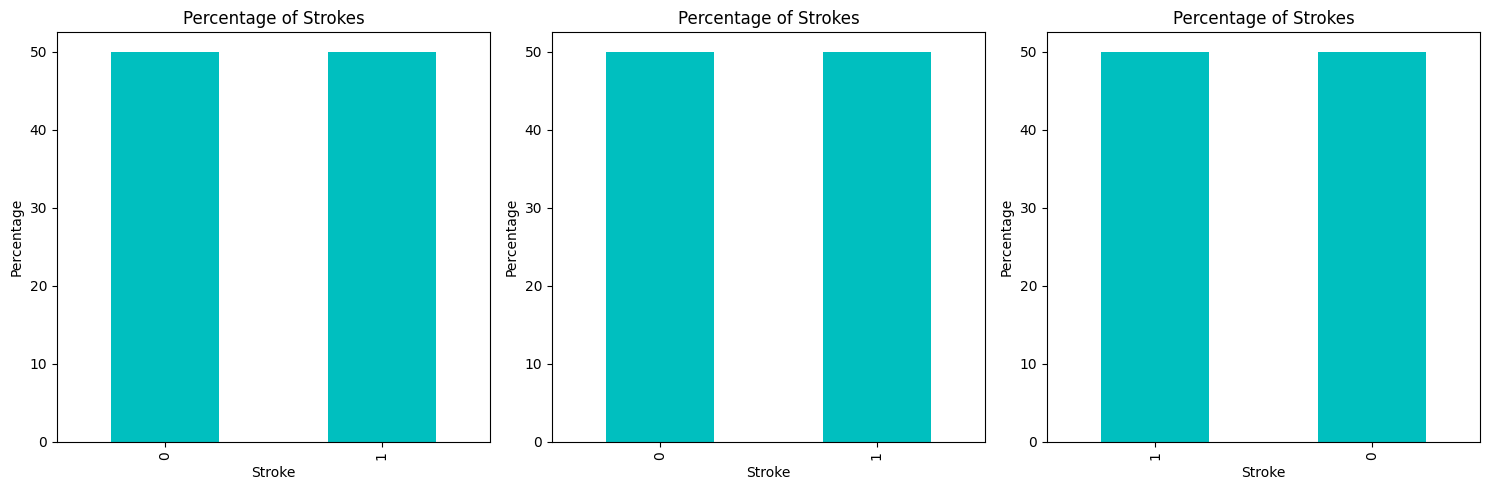

In [37]:
# Create a figure and 5 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting bar plots on each subplot
for i, y_test in zip(range(len(axs)),y_test_set):
    print(y_test.value_counts())
    values = (y_test.value_counts(normalize=True)*100)
    values.plot(kind='bar', color='c', ax=axs[i])
    axs[i].set_xlabel('Stroke')
    axs[i].set_ylabel('Percentage')
    axs[i].set_title('Percentage of Strokes')
    

plt.tight_layout()
plt.show()

In [29]:
clf = svm.SVC()
for train_x, train_y, test_x, test_y in zip(x_train_set, y_train_set, x_test_set, y_test_set):
    clf.fit(train_x, train_y)
    pred = clf.predict(test_x)
    f_score = f1_score(test_y, pred)
    prec = precision_score(test_y, pred)
    rec = recall_score(test_y, pred)
    print(f'f1: {f_score}')
    print(f'precision: {prec}')
    print(f'recall: {rec}')

f1: 0.9984136776240417
precision: 1.0
recall: 0.9968323801143862
f1: 0.9988106250825954
precision: 1.0
recall: 0.997624076029567
f1: 0.9983695412682325
precision: 1.0
recall: 0.9967443906731193


In [ ]:
scores = cross_val_score(clf, x_resampled, y_resampled, cv=sgkf, scoring='roc_auc')
print(f'mean of validation score is {scores.mean()} and the std is {scores.std()}')

<Axes: >

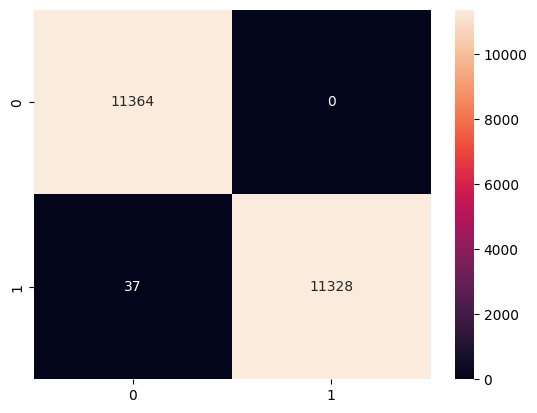

In [30]:
cm = confusion_matrix(y_test_set[2], pred)
sns.heatmap(cm, annot=True, fmt='d')

In [39]:
final_predict = clf.predict(x_test)

In [40]:
len(final_predict)

8680

In [41]:
len(y_test)

8680

In [42]:
f_s = f1_score(y_test, final_predict)
pr = precision_score(y_test, final_predict)
re = recall_score(y_test, final_predict)
print(f'f1: {f_s}')
print(f'precision: {pr}')
print(f'recall: {re}')

f1: 0.9968051118210862
precision: 1.0
recall: 0.9936305732484076


Let's try other ways

In [38]:
# for train_x, train_y, test_x, test_y in zip(x_train_set, y_train_set, x_test_set, y_test_set):
clf = svm.SVC(class_weight={1:20})
clf.fit(x_train_set[0], y_train_set[0])
pred = clf.predict(x_test_set[0])
f_score = f1_score(y_test_set[0], pred)
prec = precision_score(y_test_set[0], pred)
rec = recall_score(y_test_set[0], pred)
print(f'f1: {f_score}')
print(f'precision: {prec}')
print(f'recall: {rec}')

f1: 0.6669992370444275
precision: 0.5003742350195923
recall: 1.0


<Axes: >

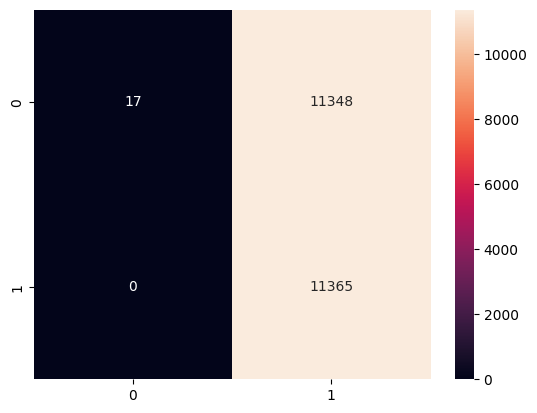

In [39]:
cm = confusion_matrix(y_test_set[0], pred)
sns.heatmap(cm, annot=True, fmt='d')

In [101]:
# for train_x, train_y, test_x, test_y in zip(x_train_set, y_train_set, x_test_set, y_test_set):
clf = svm.SVC(class_weight={1:10})
clf.fit(x_train_set[0], y_train_set[0])
pred = clf.predict(x_test_set[0])
f_score = f1_score(y_test_set[0], pred)
prec = precision_score(y_test_set[0], pred)
rec = recall_score(y_test_set[0], pred)
print(f'f1: {f_score}')
print(f'precision: {prec}')
print(f'recall: {rec}')

f1: 0.6669992370444275
precision: 0.5003742350195923
recall: 1.0


<Axes: >

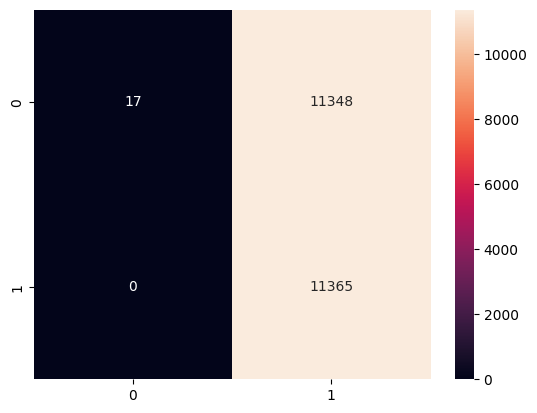

In [102]:
cm = confusion_matrix(y_test_set[0], pred)
sns.heatmap(cm, annot=True, fmt='d')

## :))))

In [43]:
classifier = svm.SVC()

In [44]:
classifier.fit(x_train, y_train)

SVC()

In [45]:
p = classifier.predict(x_test)
f1_score(y_test, p)

0.0

In [47]:
cm = confusion_matrix(y_test, p)

<Axes: >

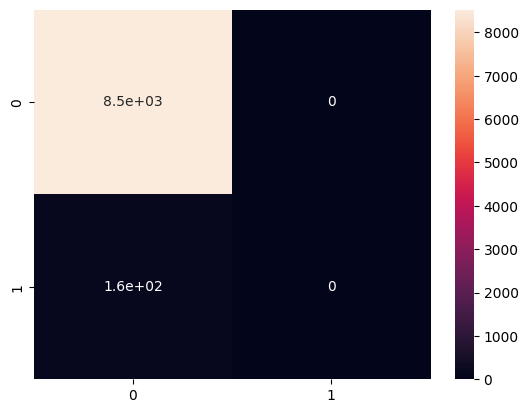

In [49]:
sns.heatmap(cm, annot=True)

In [50]:
classifier_1 = svm.SVC()
classifier_1.fit(x_train, y_train)

SVC()

In [52]:
cv = StratifiedKFold(n_splits=2)

In [ ]:
for train, test in cv.split(x_train, y_train):
    